In [2]:
import os
import cv2
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

# data augmentation
import albumentations as A

Image Data from [here](https://www.kaggle.com/c/facial-keypoints-detection/data?select=test.zip)
- Facial Keypoints

In [4]:
os.listdir('course_data/facial-keypoints-detection')

['training.csv',
 'IdLookupTable.csv',
 '.DS_Store',
 'SampleSubmission.csv',
 'test.csv']

## Augmentation for Keypoint Detection

In [9]:
data_path = 'course_data/facial-keypoints-detection'

train = pd.read_csv(data_path + '/training.csv')
test = pd.read_csv(data_path + '/test.csv')

# keypoint coordinates + image given as string of pixel values (96 x 96)
train.head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y,Image
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,...,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774,238 236 237 238 240 240 239 241 241 243 240 23...
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,...,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170,219 215 204 196 204 211 212 200 180 168 178 19...
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,...,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368,144 142 159 180 188 188 184 180 167 132 84 59 ...
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,...,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383,193 192 193 194 194 194 193 192 168 111 50 12 ...
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,...,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166,147 148 160 196 215 214 216 217 219 220 206 18...


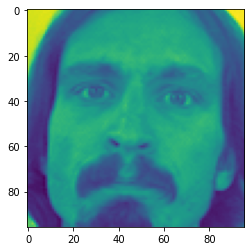

In [20]:
# convert the string into an image
def str_to_img(pixel_str):
    values = np.array([float(ele) for ele in pixel_str.split(' ')])
    img = np.reshape(values, (96, 96))
    return img

plt.imshow(str_to_img(train['Image'][0]))

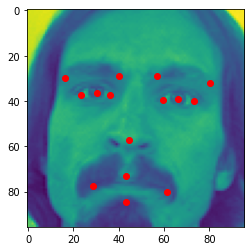

In [40]:
# display the keypoints
def display_keypoints(img, keypoint_list):
    x_values = []
    y_values = []
    # there are fifteen keypoints
    for i in range(15):
        x_values.append(keypoint_list[2*i])
        y_values.append(keypoint_list[2*i+1])
    plt.imshow(img)
    plt.scatter(x=x_values, y=y_values, c='r')

idx = 0
keypoint_list = list(train.iloc[idx][0:30])
img = str_to_img(train['Image'][idx])
    
display_keypoints(img, keypoint_list)

In [35]:
# let's make a simple dataset for our keypoint detection

class FacialKeypointDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = torch.tensor(str_to_img(row['Image'])).float()
        keypoint_values = torch.tensor(row[0:30]).float()
        
        return img, keypoint_values

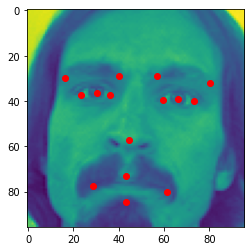

In [41]:
ds_train = FacialKeypointDataset(train)
img, keypoints = next(iter(ds_train))

# looks good!
display_keypoints(np.array(img), list(keypoints))

In [47]:
# but what about augmentation?
class FacialKeypointDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        self.transforms = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
            ])
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = str_to_img(row['Image'])
        keypoint_values = torch.tensor(row[0:30]).float()
        
        transformed = self.transforms(image=img.astype(np.uint8))
        img = torch.tensor(transformed['image']).float()
        
        return img, keypoint_values

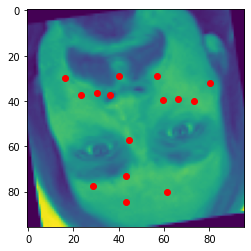

In [48]:
ds_train = FacialKeypointDataset(train)
img, keypoints = next(iter(ds_train))

# not so good now; what happened?
display_keypoints(np.array(img), list(keypoints))

In [59]:
# let's try again, this time passing the keypoints to transformation
class FacialKeypointDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
        self.transforms = A.Compose([
                # spatial transforms
                A.HorizontalFlip(p=.5),
                A.VerticalFlip(p=.5),
                A.Rotate(limit = 10, 
                         border_mode = cv2.BORDER_CONSTANT, 
                         value = 0.0, p = .75),
            ], keypoint_params=A.KeypointParams(format='xy'))
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        img = str_to_img(row['Image'])
        keypoint_values = row[0:30]
        # albumentations takes in a tuple of (x,y) values
        keypoints = []
        for i in range(int(len(keypoint_values) / 2)):
            keypoints.append((keypoint_values[2*i], keypoint_values[2*i+1]))
        
        transformed = self.transforms(image=img.astype(np.uint8), keypoints=keypoints)
        img = torch.tensor(transformed['image']).float()
        keypoints = transformed['keypoints']
        
        keypoint_values = []
        for coord_pair in keypoints:
            keypoint_values.append(coord_pair[0])
            keypoint_values.append(coord_pair[1])
        
        return img, keypoint_values

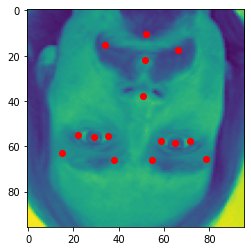

In [60]:
ds_train = FacialKeypointDataset(train)
img, keypoints = next(iter(ds_train))

# looks better now!
display_keypoints(np.array(img), list(keypoints))

Albumentations also handles bounding boxes: [see here](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/)
- difficult issue since usually only boxes along the (x,y) axis are considered!